In [15]:
import xarray as xr

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point

In [4]:
# Load Data with the open_dataset() xarray method
src_path='/work/bk1088/k204228/Climate-data-analysis-service/E63_kp40_198001_199012_T2m_daymin_merged.nc'
ds = xr.open_dataset(src_path)

# Open variable "tasmax" over the whole time range
ds_temp2 = ds["temp2"]

In [10]:
ds_temp2.time[-1]

<xarray.DataArray 'time' ()>
array('1990-12-31T09:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 1990-12-31T09:00:00
Attributes:
    standard_name:  time
    bounds:         time_bnds
    axis:           T

Select Year

In [12]:
year = "1985"
ds_temp2_year = ds_temp2.sel(time=year)

In [13]:
ds_temp2_year_count = ds_temp2_year.where(ds_temp2_year < 273.15).count(dim='time')

In [16]:
lon = ds_temp2_year_count.lon
lat = ds_temp2_year_count.lat
ds_temp2_year_count, lon = add_cyclic_point(ds_temp2_year_count, lon)

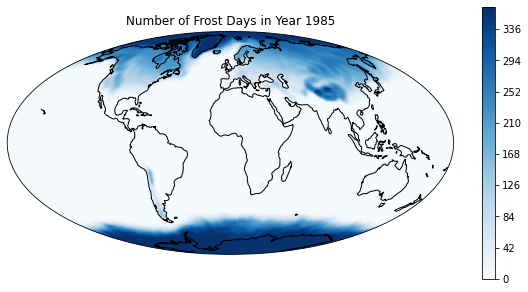

In [23]:
def main():
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mollweide())

    plt.contourf(lon, lat, ds_temp2_year_count, 60,
                transform=ccrs.PlateCarree(),
                cmap='Blues')
    ax.coastlines()
    ax.set_global()
    
    # Add a color bar
    plt.colorbar(ax=ax)
    plt.title('Number of Frost Days in Year ' +year)
    plt.show()


if __name__ == '__main__':
    main()

# ______________

This notebook computes the Frost Days index: starting from the daily minimum temperature (1980-1990) TN,
the Frost Days index is annual count of days when TN (daily minimum temperature) < 0°C

Connect to the remote ECAS instance

In [ ]:
from PyOphidia import cube
cube.Cube.setclient(read_env=True)

Import source data (minimum temperature °K)

In [ ]:
mintemp = cube.Cube(src_path='/data-training/E63_kp40_198001_199012_T2m_daymin_merged.nc',
    measure='temp2',
    import_metadata='yes',
    imp_dim='time',
    imp_concept_level='d', vocabulary='CF',hierarchy='oph_base|oph_base|oph_time',
    ncores=4,
    description='Min Temps'
    )

Identify the frost days

In [ ]:
frostdays = mintemp.apply(
    query="oph_predicate('OPH_FLOAT','OPH_INT',measure,'x-273.15','<0','1','0')"
)

Count the number of frost days

In [ ]:
count = frostdays.reduce2(
    operation='sum',
    dim='time',
    concept_level='y',
)

Plot the result

In [ ]:
firstyear = count.subset(subset_filter=1, subset_dims='time')

In [ ]:
data = firstyear.export_array(show_time='yes')
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, cm
import numpy as np

lat = data['dimension'][0]['values'][:]
lon = data['dimension'][1]['values'][:]
var = data['measure'][0]['values'][:]
var = np.reshape(var, (len(lat), len(lon)))

fig = plt.figure(figsize=(15, 15), dpi=100)
ax  = fig.add_axes([0.1,0.1,0.8,0.8])

map = Basemap(projection='cyl',llcrnrlat= -90,urcrnrlat= 90, llcrnrlon=0,urcrnrlon=360, resolution='c')

map.drawcoastlines()
map.drawparallels(np.arange( -90, 90,30),labels=[1,0,0,0])
map.drawmeridians(np.arange(-180,180,30),labels=[0,0,0,1])

x, y = map(*np.meshgrid(lon,lat))

clevs = np.arange(0,371,10)

cnplot = map.contourf(x,y,var,clevs,cmap=plt.cm.jet)
cbar = map.colorbar(cnplot,location='right')

plt.title('Frost Days (year 1980)')
plt.show()

To clear your workspace before running other notebooks

In [ ]:
cube.Cube.client.submit("oph_delete cube=[container=E63_kp40_198001_199012_T2m_daymin_merged.nc]")
cube.Cube.deletecontainer(container='E63_kp40_198001_199012_T2m_daymin_merged.nc')